In [1]:
# import reqs
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
from pydub import AudioSegment
import re
import subprocess
import requests
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# connect the video files
video_files = './video_files'
audio_files = './audio_files'
text_files = './text_files'

folders = [video_files, audio_files, text_files]
for folder in folders:
    # Check if the output folder exists
    if not os.path.exists(folder):
    # If not, create the folder
        os.makedirs(folder)

In [14]:
# extract the audio from the video and export the audio as a wav file
for video_file in os.listdir(video_files):
    if video_file.endswith('.mp4'):
        video_path = os.path.join(video_files, video_file)
        audio = AudioSegment.from_file(video_path, format="mp4")
        audio.export(os.path.join(audio_files, f"{video_file[:-4]}.wav"), format="wav")

In [16]:
# function to transcribe and save the output in txt file
def transcribe_and_save(audio_files, text_files, model='medium.en'):
    # Construct the Whisper command
    whisper_command = f"whisper '{audio_files}' --model {model}"
    
    try:
        # Run the Whisper command
        transcription = subprocess.check_output(whisper_command, shell=True, text=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        print(f"Error during transcription: {e.output}")
        return
    
    # Clean and join the sentences
    output_without_time = re.sub(r'\[\d+:\d+\.\d+ --> \d+:\d+\.\d+\]  ', '', transcription)
    sentences = [line.strip() for line in output_without_time.split('\n') if line.strip()]
    joined_text = ' '.join(sentences)

    # Create the corresponding text file name
    audio_file_name = os.path.basename(audio_files)
    text_file_name = os.path.splitext(audio_file_name)[0] + '.txt'
    file_path = os.path.join(text_files, text_file_name)

    # Save the output as a txt file
    with open(file_path, 'w') as file:
        file.write(joined_text)

    print(f'Text for {audio_file_name} has been saved to: {file_path}')


# Transcribing all the audio files in the directory
for audio_file in os.listdir(audio_files):
    if audio_file.endswith('.wav'):
        audio_files = os.path.join(audio_files, audio_file)
        transcribe_and_save(audio_files, text_files)

# This will take a while to trduge through, be patient, its a lot of data for a 5 min video

100%|█████████████████████████████████████| 1.42G/1.42G [02:37<00:00, 9.71MiB/s]
/Users/shayonkeating/anaconda3/envs/pydata/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Text for parkinsons_disease.wav has been saved to: ./text_files/parkinsons_disease.txt


### Making the knowledge graph

In [120]:
# Global Constants API endpoint, API key, prompt text
import requests
import os
import re
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from openai import OpenAI
from utils import read_api_key
api_key_file_path = './auth/api_key.txt'
api_key = read_api_key(api_key_file_path)
prompt_text = """Based on the given prompt, identify and enumerate all possible connections, then compile a summary of updates. 
For each update involving a connection, format it as [ENTITY 1, CONNECTION, ENTITY 2]. This connection is directional, 
indicating the sequence is significant.
Example:
prompt: The Sun generates solar energy and is also responsible for Vitamin D production.
updates:
[["Sun", "generates", "solar energy"], ["Sun", "responsible for", "Vitamin D"]]
prompt: $prompt
updates:"""

# Initialize the OpenAI client with your API key
client = OpenAI(api_key = api_key)


def call_gpt_api(prompt_text):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt_text}],
            temperature=0,
            max_tokens=3000,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        print(response)
        return response
    except Exception as e:
        print("Error:", e)
        return None


# Data Preparation Function
def preparing_data_for_graph(api_response):
    if api_response is None:
        print("API response is None. Exiting function.")
        return None, None

  
    try:
        # Accessing the 'content' from the API response
        response_text = api_response.choices[0].message.content
        print("Response Text:", response_text)  # Debug print

        # Remove enumeration and prepare the content for JSON parsing
        cleaned_content = re.sub(r'\d+\.\s+', '', response_text)  # Remove leading numbers and spaces
        print("Cleaned Content:", cleaned_content)  # Debug print

        # Split by new lines and reformat as JSON array, ensuring non-empty items are wrapped correctly
        # Each item is already a JSON array, so no need for additional quotes or escaping
        cleaned_content = '[' + ','.join(cleaned_content.split('\n')) + ']' 
        print("JSON Array String:", cleaned_content)  # Debug print

        # Parse the JSON array of arrays
        structured_data = json.loads(cleaned_content)
        print("Structured Data:", structured_data)  # Debug print

        # Remove one level of nesting from structured_data
        # Each item should be a list with three elements: source, relation, target
        structured_data = [item[0] for item in structured_data if isinstance(item, list) and len(item) > 0]
        print("Flattened Structured Data:", structured_data)  # Debug print

        # Extract source, target, and relations while ensuring list has enough elements
        source = [item[0] for item in structured_data if len(item) > 2]
        target = [item[2] for item in structured_data if len(item) > 2]
        relations = [item[1] for item in structured_data if len(item) > 2]
        print("Source:", source)  # Debug print
        print("Target:", target)  # Debug print
        print("Relations:", relations)  # Debug print

        # Create DataFrame from the extracted elements
        kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
        relation_labels = dict(zip(zip(kg_df.source, kg_df.target), kg_df.edge))
        print("DataFrame:", kg_df)  # Debug print
        print("Relation Labels:", relation_labels)  # Debug print

        return kg_df, relation_labels
    except Exception as e:
        print(f"Error processing API response: {e}")
        return None, None


# Graph Creation Function
def create_graph(df, rel_labels):
    G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
    plt.figure(figsize=(12, 12), dpi=100)  # Increased DPI for better resolution

    pos = nx.spring_layout(G, k=0.5)  # Adjust layout parameters
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', width=2, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=rel_labels, font_color='red')

    save_path = os.path.join('text_files', 'graph_image.png')
    plt.savefig(save_path)  # Save the figure before showing it
    plt.show()  # Show the plot
    plt.close()  # Close the figure to ensure clean state for next plot

    print(f"Graph image saved to: {save_path}")


def main(text_file_path):
    with open(text_file_path, 'r') as file:
        kb_text = file.read()
    global prompt_text
    prompt_text = prompt_text.replace("$prompt", kb_text)

    api_response = call_gpt_api(prompt_text)  # call gpt function
    if api_response:
        df, rel_labels = preparing_data_for_graph(api_response)  # build the data graph
        
        # Toss an error if no graph is made cause dict is empty
        if df is not None and rel_labels is not None:
            create_graph(df, rel_labels)
        else:
            print("Data preparation failed. Unable to create graph.")
    else:
        print("API call failed. Unable to process the text file.")


def start(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            # Construct the full path to the text file
            text_file_path = os.path.join(directory_path, filename)
            # Call the main function for each text file
            main(text_file_path)

ChatCompletion(id='chatcmpl-8vFf4s4Apod5CsF1KeoO5hal0DQfO', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='1. [["Parkinson\'s disease", "has", "different subtypes"]]\n2. [["Parkinson\'s disease", "described as", "tremor-dominant form"]]\n3. [["tremor-dominant form of Parkinson\'s disease", "starts at", "ages 45-55"]]\n4. [["essential tremor", "confused with", "Parkinson\'s disease"]]\n5. [["essential tremor", "may evolve into", "tremor-dominant form of Parkinson\'s disease"]]\n6. [["tremor-dominant form of Parkinson\'s disease", "has", "favorable prognosis"]]\n7. [["PIGD form of Parkinson\'s disease", "progresses more rapidly than", "tremor-dominant form"]]\n8. [["PIGD form of Parkinson\'s disease", "less responsive to", "levodopa"]]\n9. [["young onset Parkinson\'s disease", "more vulnerable to", "levodopa side effects"]]\n10. [["late onset Parkinson\'s disease", "more likely to develop", "cognitive decline and dementia"]]\n11. [["P

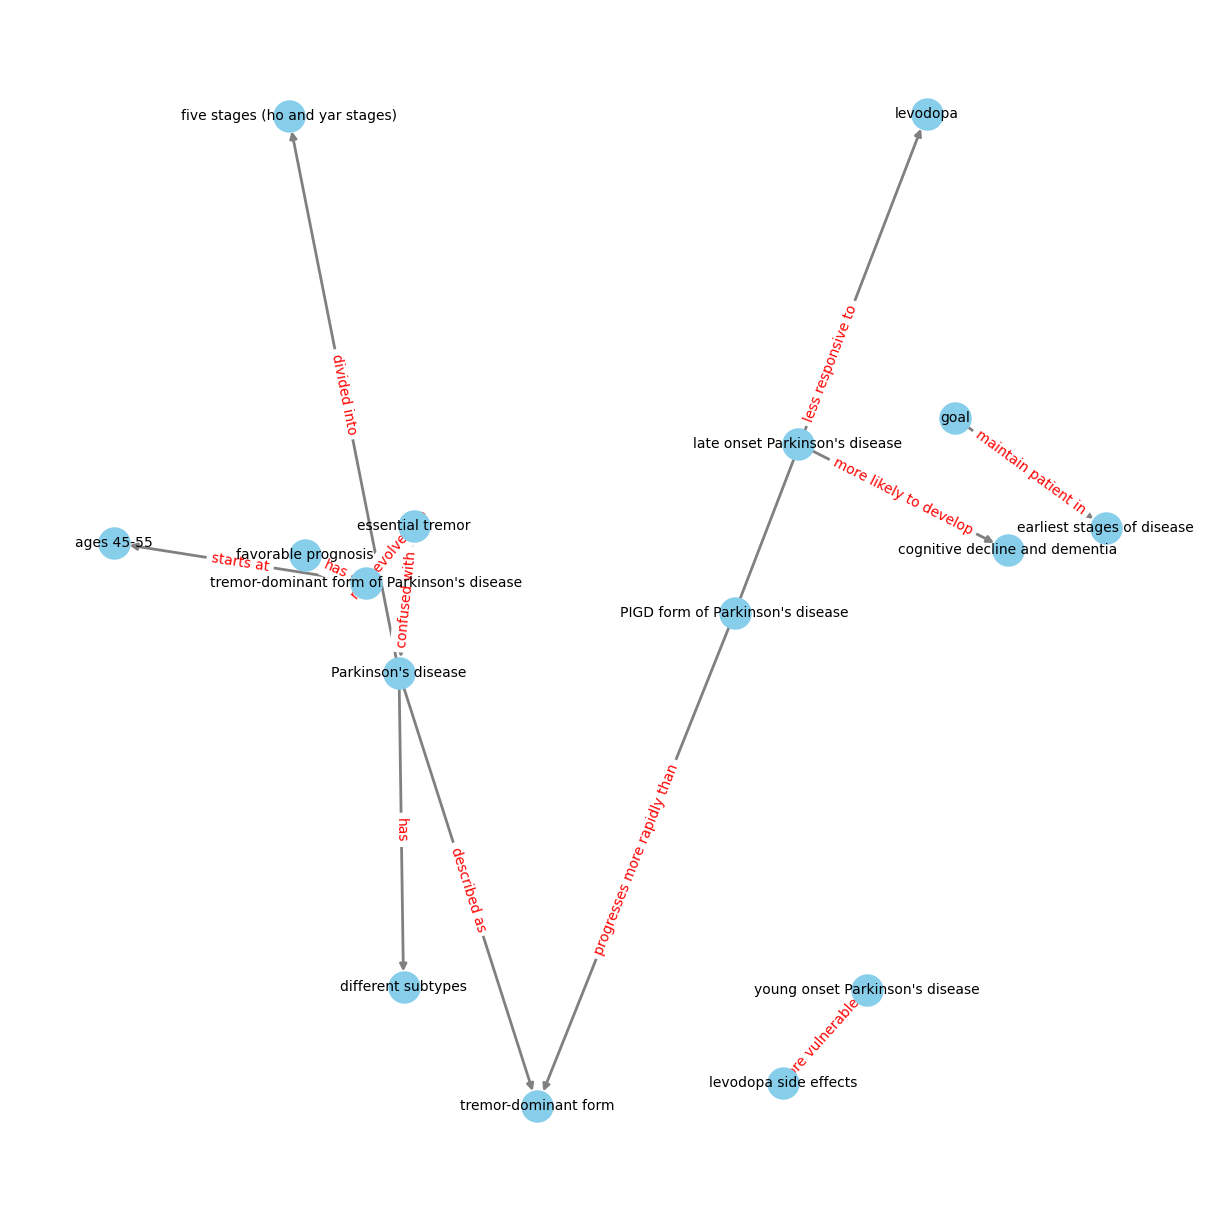

Graph image saved to: text_files/graph_image.png


In [121]:
start('./text_files')

In [93]:
import json

# Your API response using triple quotes to avoid escape character issues
api_response = """{"id":"chatcmpl-8vC0QVwaNAVkqzepQmz8YuhkuIpsF","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":"1. [[\\"Parkinson's disease\\", \\"has\\", \\"different subtypes\\"]]\n2. [[\\"Parkinson's disease\\", \\"described as\\", \\"tremor-dominant form\\"]]\n3. [[\\"tremor-dominant form of Parkinson's disease\\", \\"starts at\\", \\"ages 45-55\\"]]\n4. [[\\"essential tremor\\", \\"confused with\\", \\"Parkinson's disease\\"]]\n5. [[\\"essential tremor\\", \\"may evolve into\\", \\"tremor-dominant form of Parkinson's disease\\"]]\n6. [[\\"tremor-dominant form of Parkinson's disease\\", \\"has\\", \\"favorable prognosis\\"]]\n7. [[\\"PIGD form of Parkinson's disease\\", \\"progresses more rapidly than\\", \\"tremor-dominant form\\"]]\n8. [[\\"PIGD form of Parkinson's disease\\", \\"less responsive to\\", \\"levodopa\\"]]\n9. [[\\"young onset Parkinson's disease\\", \\"more vulnerable to\\", \\"levodopa side effects\\"]]\n10. [[\\"late onset Parkinson's disease\\", \\"more likely to develop\\", \\"cognitive decline and dementia\\"]]\n11. [[\\"Parkinson's disease\\", \\"divided into\\", \\"five stages (ho and yar stages)\\"]]\n12. [[\\"goal\\", \\"maintain patient in\\", \\"earliest stages of disease\\"]]","role":"assistant","function_call":null,"tool_calls":null}}],"created":1708641538,"model":"gpt-3.5-turbo-0125","object":"chat.completion","system_fingerprint":"fp_cbdb91ce3f","usage":{"completion_tokens":263,"prompt_tokens":1041,"total_tokens":1304}}"""

# Parse the JSON string into a Python object
data = json.loads(api_response)

# Extract the message content from the first choice
message_content = data["choices"][0]["message"]["content"]

# Print the message content
print(message_content)

1. [[\"Parkinson's disease\", \"has\", \"different subtypes\"]]\n2. [[\"Parkinson's disease\", \"described as\", \"tremor-dominant form\"]]\n


In [ ]:
def preparing_data_for_graph(api_response):
    if api_response is None:
        print("API response is None. Exiting function.")
        return None, None
